In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

Necessary libraries are downloaded. I used both Random Forest and XGBoost to see which produces a better performance on this dataset.

In [2]:
df = pd.read_csv('AnkaraHousePrices.csv')

Dataset is uploaded. This is the first time that I have built an ML model on a dataset which I scraped :)

In [3]:
df.head()

,Age,Area,CreditAvlb,Firsthand,FloorCount,FloorNumber,Frontage,Fuel,Furniture,Heating,MaintenanceFee,Price,Room,Town,Typeofit
0,0,240,Uygun,Sıfır,15.0,15,"Güney,Doğu,Batı",Doğalgaz,Eşyalı Değil,Merkezi (Pay Ölçer),250,1200000,5,Keçiören,Daire
1,2,190,Uygun,İkinci El,11.0,9,"Kuzey,Güney,Doğu,Batı",Doğalgaz,Eşyalı Değil,Merkezi (Pay Ölçer),NaN,799000,5,Etimesgut,Daire
2,3,300,Uygun,İkinci El,3.0,3,"Güney,Batı",Doğalgaz,Eşyalı Değil,Kombi,60,448000,5,Etimesgut,Daire
3,0,412,Uygun,NaN,14.0,13,NaN,NaN,Eşyalı Değil,Kombi,NaN,975000,6,Pursaklar,Daire
4,0,206,Uygun,NaN,14.0,10,NaN,NaN,Eşyalı Değil,Kombi,NaN,590000,5,Pursaklar,Daire


The first 5 rows are brought for EDA. We see that most features are not numeric. So I will need to clean and tidy them since scikit learn library can handle only numeric data types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22957 entries, 0 to 22956
Data columns (total 15 columns):
Age               22957 non-null int64
Area              22957 non-null object
CreditAvlb        22957 non-null object
Firsthand         20730 non-null object
FloorCount        22069 non-null float64
FloorNumber       22408 non-null object
Frontage          19494 non-null object
Fuel              21284 non-null object
Furniture         22957 non-null object
Heating           22957 non-null object
MaintenanceFee    14659 non-null object
Price             22957 non-null int64
Room              22957 non-null int64
Town              22957 non-null object
Typeofit          22957 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 2.6+ MB


Some further exploratory data analysis. It can be seen that there are some null values. Most of the features are object-type some of them will be int or float type automatically after we get rid of null values. So let's check how many null values there are in each feature.

In [5]:
df.isnull().sum()

Age                  0
Area                 0
CreditAvlb           0
Firsthand         2227
FloorCount         888
FloorNumber        549
Frontage          3463
Fuel              1673
Furniture            0
Heating              0
MaintenanceFee    8298
Price                0
Room                 0
Town                 0
Typeofit             0
dtype: int64

There are quite a lot of null values. Dropping all of them doesn't seem like an effective solution to me. So I will handle each on its own way by using some domain knowledge regarding houses in Ankara. 

In [6]:
[row for row in df['Area'] if not row.isnumeric()]

['1,140',
 '3,000',
 '1,160',
 '1,801',
 '1,000',
 '1,120',
 '1,000',
 '2,320',
 '1,000',
 '1,250',
 '11,500']

The first feature is "Age". It is already integer-type and it doesn't have any null values. So I skip it for now.

I start cleaning from "Area" feature. I used an if statement in a list comprehension to see what makes the feature object-type. I will convert these inputs to integer after getting rid of comma. 

In [7]:
df['Area'] = df['Area'].apply(lambda x: x.replace(',', '')).astype(int)

A simply function to get rid of comma sign. 

In [8]:
df['Area'].dtype

dtype('int64')

Area feature is now integer type.

In [9]:
df['CreditAvlb'].value_counts()

Uygun          22526
Uygun değil      228
Bilinmiyor       203
Name: CreditAvlb, dtype: int64

Next feature is CreditAvlb. This feature shows us if house is available to use mortgage credit from a bank. Vast majority of them are available as we see. We will convert these categorical inputs to numeric values because scikit learn can handly only numeric values.

In [10]:
df['CreditAvlb'].replace(('Uygun', 'Bilinmiyor', 'Uygun değil'), (2,1,0), inplace=True)

I used in this case replace method to convert them to numeric values.

In [11]:
df['CreditAvlb'].dtype

dtype('int64')

CreditAvlb feature is now integer type.

In [12]:
df['Firsthand'].value_counts()

İkinci El           14642
Sıfır                6019
Yapım Aşamasında       69
Name: Firsthand, dtype: int64

I used value_counts() method again to check what inputs this feature have. There are 3 different inputs for this feature as well. 

In [13]:
df['Firsthand'].replace(('Sıfır', 'İkinci El', 'Yapım Aşamasında'), (2,1,0), inplace=True)

I converted them to numeric values, too.

In [14]:
df['Firsthand'].dtype

dtype('float64')

datatype is still object because it has some null values. We need to take care of them to be able to convert the feature to integer type. 

In [15]:
df['Firsthand'].isnull().sum()

2227

In [16]:
df['Firsthand'].mode()

0    1.0
dtype: float64

We will replace the null values with the mode in this particular case.  

In [17]:
df['Firsthand'].fillna(1.0, inplace = True)

Replacement is implemented. 

In [18]:
df['Firsthand'] = df['Firsthand'].astype(int)

astype() method forces the feature to convert its type to integer. 

In [19]:
df['Firsthand'].dtype

dtype('int64')

In [20]:
df.Typeofit.value_counts()

Daire    22957
Name: Typeofit, dtype: int64

In [21]:
df.drop('Typeofit', axis = 1, inplace=True)

Typeofit column has only one different value so we can drop it. 

In [22]:
df['MaintenanceFee'] = df['MaintenanceFee'].str.replace(',', '')
df['MaintenanceFee'] = df['MaintenanceFee'].fillna(0)
df['MaintenanceFee'] = df['MaintenanceFee'].astype(int)

MaintenanceFee feature is cleaned and converted to integer type. 

In [23]:
df['MaintenanceFee'].dtype

dtype('int64')

In [24]:
Le_Heating=LabelEncoder()
df['Heating_num'] = Le_Heating.fit_transform(df['Heating'])
df.drop(['Heating'], axis = 1, inplace=True)

I used label encoding to convert the type of the feature here because I implemented tree-based models in this particular case. Label encoding, one-hot encoding or replace method don't make much difference for tree-based models. One-hot encoding could lead to curse of dimensionality if you don't pay atteniton, so I avoided it just in case.

In [25]:
df['Heating_num'].dtype

dtype('int64')

The name of the new numeric type column is Heating_num.

In [26]:
df['Furniture'].value_counts()

Eşyalı Değil    22437
Eşyalı            520
Name: Furniture, dtype: int64

In [27]:
df['Furniture'].replace(('Eşyalı', 'Eşyalı Değil'), (1, 0), inplace=True)

I converted the type of 'Furniture' feature.

In [28]:
df['Furniture'].dtype

dtype('int64')

In [29]:
df['Fuel'].value_counts()

Doğalgaz      21171
Elektrik         64
Kömür-Odun       38
Akaryakıt        11
Name: Fuel, dtype: int64

In [30]:
df['Fuel'].replace(('Doğalgaz', 'Elektrik', 'Akaryakıt', 'Kömür-Odun', ), (3,2,1,0), inplace=True)
df['Fuel'].fillna(3, inplace=True)
df['Fuel'] = df['Fuel'].astype(int)

Further cleansing.

In [31]:
df['Fuel'].dtype

dtype('int64')

In [32]:
df.dropna(subset = ['FloorCount'], inplace=True)

I prefer dropping the rows which have null values in this case. Because the number of null values are not as many as null values in other columns. Also this feature has greater importance in my opinion(well, I could have measured to check if it really has greater importance than others but i didn't) and to filling null values here with mode or median could mislead the whole model accuracy. 

In [33]:
 df['FloorCount'] = df['FloorCount'].astype(int)

In [34]:
df['FloorCount'].dtype

dtype('int64')

We are done with FloorCount to clean.

In [35]:
df.groupby('Town').Price.agg(['count', 'min', 'max', 'mean']).sort_values('mean')

,count,min,max,mean
Town,,,,
Haymana,1,101000,101000,1.010000e+05
Nallıhan,1,120000,120000,1.200000e+05
Akyurt,27,85000,499000,1.915370e+05
Polatlı,204,65000,500000,2.101471e+05
Elmadağ,10,125000,430000,2.181000e+05
Çubuk,77,95000,535000,2.257532e+05
Sincan,672,175,600000,2.313797e+05
Mamak,3567,105,870000,2.412661e+05
Kızılcahamam,5,37000,475000,2.450000e+05


I need to convert 'Town' feature. I wanted to give some meaningful numeric values to this feature. So I thought I can put them in order according to their mean value. We see min, max, count, and mean values of each town.

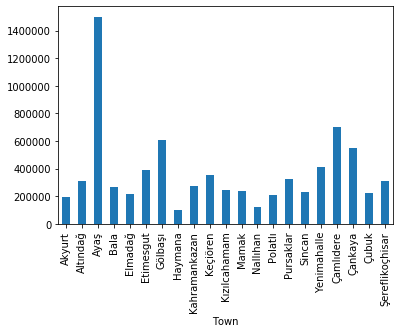

In [36]:
df.groupby('Town').Price.mean().plot(kind='bar')

Here is a nice visualization to understand the prices in each town.

In [37]:
df.groupby('Town').Price.mean().sort_values().astype(int)

Town
Haymana             101000
Nallıhan            120000
Akyurt              191537
Polatlı             210147
Elmadağ             218100
Çubuk               225753
Sincan              231379
Mamak               241266
Kızılcahamam        245000
Bala                265000
Kahramankazan       273518
Altındağ            308190
Şereflikoçhisar     310000
Pursaklar           325139
Keçiören            352595
Etimesgut           391760
Yenimahalle         411673
Çankaya             551314
Gölbaşı             610517
Çamlıdere           700000
Ayaş               1500000
Name: Price, dtype: int64

I sorted them for a better insight.

In [38]:
df['Town'].replace(('Gölbaşı', 'Çankaya', 'Yenimahalle', 'Etimesgut', 'Keçiören', 'Pursaklar', 'Altındağ', 'Mamak', 'Sincan', 'Polatlı', 'Kahramankazan', 'Kızılcahamam', 'Çamlıdere', 'Şereflikoçhisar', 'Çubuk', 'Elmadağ', 'Akyurt','Nallıhan', 'Akyurt', 'Haymana', 'Ayaş', 'Bala'), (10,9,8,7,6,5,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1), inplace=True)

I replaced string values with numeric ones according to the sorted list above. I ended up using a tree based model and this order didnt make much sense for this reason but i decided to leave them as they are.

In [39]:
df['Town'].value_counts()

9     7707
3     3567
6     3419
7     2271
8     1724
5     1035
4     1029
2      672
1      356
10     289
Name: Town, dtype: int64

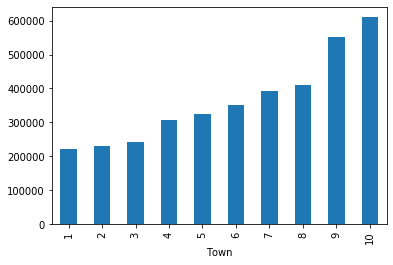

In [40]:
df.groupby('Town').Price.mean().plot(kind='bar')

Visualization after numeration.

In [41]:
df['Frontage'].value_counts()

Güney,Doğu               4009
Güney,Batı               3042
Güney,Doğu,Batı          2358
Güney                    1973
Kuzey,Güney,Doğu,Batı    1309
Doğu                     1095
Kuzey,Batı               1039
Kuzey,Doğu                975
Batı                      960
Doğu,Batı                 619
Kuzey,Doğu,Batı           594
Kuzey,Güney,Doğu          457
Kuzey,Güney,Batı          341
Kuzey,Güney               213
Kuzey                     135
Name: Frontage, dtype: int64

In [42]:
df['Frontage'] = df['Frontage'].str.contains('Kuzey', na= False, regex = False)

In [43]:
df['Frontage'].astype(int)

0        0
1        1
2        0
3        0
4        0
        ..
22952    0
22953    0
22954    0
22955    0
22956    0
Name: Frontage, Length: 22069, dtype: int64

In [44]:
df['Frontage'] = df['Frontage'].replace({0:1, 1:0})

I thought 1 should be assigned to the better frontage option, so that's why I swapped them.

In [45]:
df['Frontage'].value_counts()

1    17006
0     5063
Name: Frontage, dtype: int64

In [46]:
df.isnull().sum()

Age               0
Area              0
CreditAvlb        0
Firsthand         0
FloorCount        0
FloorNumber       0
Frontage          0
Fuel              0
Furniture         0
MaintenanceFee    0
Price             0
Room              0
Town              0
Heating_num       0
dtype: int64

No null values left.

In [47]:
df['FloorNumber'].value_counts()

1                  4706
3                  3870
2                  3557
Yüksek Giriş       1786
4                  1662
Giriş Katı         1177
5                   801
Bahçe Katı          562
6                   515
7                   391
8                   376
9                   332
En Üst Kat          303
10                  272
12                  235
11                  220
21                  180
Teras Katı          177
13                  143
Ara Kat             131
14                  130
Zemin               130
15                   89
Çatı Katı            54
17                   52
16                   49
20                   39
Villa Katı           37
18                   34
19                   25
Yarı Bodrum          14
Bodrum ve Zemin      11
Bodrum                6
Asma Kat              3
Name: FloorNumber, dtype: int64

In [48]:
df['FloorNumber'].replace(('Yüksek Giriş', 'Giriş Katı', 'Bahçe Katı', 'En Üst Kat', 'Teras Katı', 'Ara Kat', 'Zemin', 'Çatı Katı', 'Villa Katı', 'Yarı Bodrum', 'Bodrum ve Zemin', 'Bodrum', 'Asma Kat'), (0.5, 0, 0.25, np.nan, np.nan, 2, 0, np.nan, 0.75, -0.50, -0.50, -1, 1.5 ), inplace=True)

There are some rows named "top floor" I decided to assign the value of the FloorCount for that. Because basically they mean same thing and we prefer numeric ones. First, I assigned null values for this kind of rows to make replacement process easier.

In [49]:
df.isnull().sum()

Age                 0
Area                0
CreditAvlb          0
Firsthand           0
FloorCount          0
FloorNumber       534
Frontage            0
Fuel                0
Furniture           0
MaintenanceFee      0
Price               0
Room                0
Town                0
Heating_num         0
dtype: int64

In [50]:
df.FloorNumber = np.where(df.FloorNumber.isnull(), df.FloorCount, df.FloorNumber)

I replaced null values with the FloorCount rows which have same index.

In [51]:
df['FloorNumber'] = df['FloorNumber'].astype(float)

In [52]:
df['FloorNumber'].value_counts()

 1.00     4706
 3.00     4084
 2.00     3708
 4.00     1821
 0.50     1786
 0.00     1307
 5.00      864
 0.25      562
 6.00      524
 7.00      402
 8.00      384
 9.00      338
 10.00     282
 12.00     249
 11.00     222
 21.00     181
 13.00     149
 14.00     132
 15.00      92
 17.00      54
 16.00      49
 20.00      41
 0.75       37
 18.00      34
-0.50       25
 19.00      25
-1.00        6
 1.50        3
 24.00       2
Name: FloorNumber, dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22069 entries, 0 to 22956
Data columns (total 14 columns):
Age               22069 non-null int64
Area              22069 non-null int64
CreditAvlb        22069 non-null int64
Firsthand         22069 non-null int64
FloorCount        22069 non-null int64
FloorNumber       22069 non-null float64
Frontage          22069 non-null int64
Fuel              22069 non-null int64
Furniture         22069 non-null int64
MaintenanceFee    22069 non-null int64
Price             22069 non-null int64
Room              22069 non-null int64
Town              22069 non-null int64
Heating_num       22069 non-null int64
dtypes: float64(1), int64(13)
memory usage: 3.2 MB


We see that there is no null value left and all values are converted to numeric.

In [54]:
indexAge = df [ df.Age > 100 ].index
df.drop(indexAge , inplace=True)

In [55]:
indexNames = df [ df.Room > 10 ].index
df.drop(indexNames , inplace=True)

In [56]:
indexPrices = (df[(df['Price'] <40000 ) | (df['Price'] > 10000000)]).index
df.drop(indexPrices, inplace = True)

In [57]:
indexFloorCount = df [ df.FloorCount > 50 ].index
df.drop(indexFloorCount, inplace = True)

In [58]:
indexMaintenanceFee = df [ df.MaintenanceFee > 2500 ].index
df.drop(indexMaintenanceFee, inplace = True)

In [59]:
indexArea = (df[(df['Area'] > 750 ) | (df['Area'] < 10)]).index
df.drop(indexArea, inplace = True)

I have done some data cleansing further. I dropped some rows which don't represent real world use cases. They seem like to be entered mistakenly(For example, in terms of house prices, 3 zeros are missing in the end or stuff like this) They can be corrected as well but I couldn't make sure and thought it is best to drop them.

In [60]:
df.head(7)

,Age,Area,CreditAvlb,Firsthand,FloorCount,FloorNumber,Frontage,Fuel,Furniture,MaintenanceFee,Price,Room,Town,Heating_num
0,0,240,2,2,15,15.0,1,3,0,250,1200000,5,6,7
1,2,190,2,1,11,9.0,0,3,0,0,799000,5,7,7
2,3,300,2,1,3,3.0,1,3,0,60,448000,5,7,5
3,0,412,2,1,14,13.0,1,3,0,0,975000,6,5,5
4,0,206,2,1,14,10.0,1,3,0,0,590000,5,5,5
5,18,245,2,1,3,3.0,1,3,0,50,415000,5,9,5
6,35,185,2,1,3,3.0,1,3,0,70,525000,5,9,5


Taking another look at the dataset after converting all features to integer to see if everthing is allright.

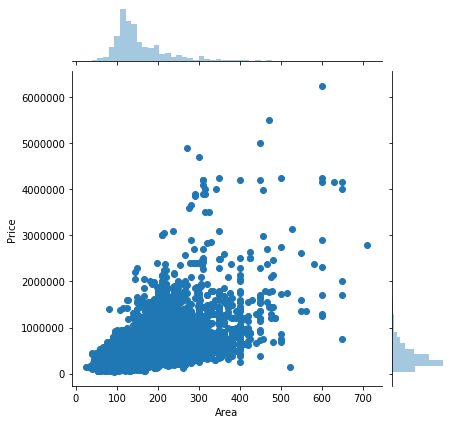

In [61]:
sns.jointplot(x='Area', y='Price',  data=df )

This plot shows us the distribution of Area and Price columns. Seaborn library is used to visualize. This plot was actually used many times up to here for outlier detection. But I only keep one of them for the sake of simplicity.

In [62]:
#df.to_csv('AnkaraHousesDatasetProduction.csv', index=False)
#I used this opeartion only once.

In [63]:
y=df.loc[:, 'Price']
X=df.loc[:, df.columns != 'Price']

Target variable and predictors are assigned.

In [64]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

Train and test set are splitted. 80% for training, 20% for validation. Random_state is assigned to get the same result if model is reexecuted later.

In [65]:
param_grid={"n_estimators":[100, 250],
"max_depth": [8,12,14],
"min_samples_leaf": [2,4] }

Hyper parameters are assisned as a list. The range for each parameter consists of 2  or 3 values in order to save time and computational power.

In [66]:
RFReg=RandomForestRegressor(n_jobs=-1, random_state=42)

I tried many different models and opted for Random Forest Regressor in the end as it produced the best accuracy score among them.

In [67]:
RFReg_cv= GridSearchCV(RFReg, param_grid, cv=10)

I used grid search to optimize hyper parameters. Tried different cross validation values(5 and 10) it didn't make any difference.

In [68]:
RfReg_cv_result = RFReg_cv.fit(X_train, y_train)

In [69]:
y_pred=RfReg_cv_result.predict(X_test)

In [70]:
rmse=mean_squared_error(y_test, y_pred)**0.5

In [71]:
rmse

126156.01279200938

In [72]:
RFReg_cv.score(X_test, y_test) 

0.817862390429281

In [73]:
RFReg_cv.score(X_train, y_train) 

0.9213205567312204

In [74]:
RfReg_cv_result.best_params_

{'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 250}